In [7]:
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
import math
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import cv2
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
%matplotlib inline

def list_sort_nicely(l):
    def tryint(s):
        try:
            return int(s)
        except:
            return s
    
    def alphanum_key(s):
        return [ tryint(c) for c in re.split('([0-9]+)', s)]
    l.sort(key=alphanum_key)
    return l

/home/danny7454/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
centers = [0.20207, 0.38160, 0.56472]

test_data_dir = "/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/final_inference/testset_gif/nifti/*.nii.gz"
test_data_list = list_sort_nicely(glob.glob(test_data_dir))
print(len(test_data_list))

output_data_dir = "/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/final_inference/multitasking_G_256/test22/nifti/*.nii.gz"
output_data_list = list_sort_nicely(glob.glob(output_data_dir))
print(len(output_data_list))

train_data_dir = "/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/final_dataset/train/map_nifti/*.nii.gz"
train_data_list = list_sort_nicely(glob.glob(train_data_dir))
print(len(train_data_list))

Xe_VDP_test = []
Xe_VDP_train = []
DL_VDP = []
Xe_VDP = []

6000
6000
42600


In [10]:
print(test_data_list[0][-27:-24])

008


In [11]:
import time

output_data_dir = "/mnt/nas203/forGPU/leesangy/final_inference/pix2pix_256/test22/nifti/*.nii.gz"
output_data_list = list_sort_nicely(glob.glob(output_data_dir))
print(len(output_data_list))

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    sum_pixels = np.sum(y_true) + np.sum(y_pred)
    dice = 2.0 * intersection / sum_pixels if sum_pixels > 0 else 0.0
    return dice

per_patient_vdp = []
patient = "none"
start_time = time.time()

for i in range(len(test_data_list)):
    test_data = test_data_list[i]
    
    if test_data[-27:-24] != patient:
        patient = test_data[-27:-24]
        Xe_VDP_test.append(np.mean(per_patient_vdp))
        per_patient_vdp = []
        print(patient)
    
    test_file = nib.load(test_data)
    test_data = np.rot90(test_file.get_fdata().squeeze(), k=3)
    test_copied = test_data.copy()
    test_background_mask = (test_data != 0)
    
    lung_surface = np.count_nonzero(test_background_mask)
    
    test_copied[(test_copied > 0) & (test_copied < centers[0])] = 2
    test_copied[(test_copied >= centers[0]) & (test_copied <=1)] = 0
    test_copied[test_copied ==2]= 1
    
    #plt.imshow(test_copied)
    #plt.show()
    
    defect_surface = np.count_nonzero(test_copied)
    vdp_percentage = defect_surface / lung_surface * 100
    
    #print(vdp_percentage)
    
    per_patient_vdp.append(vdp_percentage)
    
    if i == 5999:
        print(i)
        Xe_VDP_test.append(np.mean(per_patient_vdp))
        
    if i == "nan":
        print(i)
    
    if i % 500 == 0:
        
        print(i, (time.time()-start_time)/60, "min")

0
008
0 0.000311128298441569 min


/home/danny7454/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/danny7454/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


015
019
500 0.18729357322057089 min
021
025
027
1000 0.36132835149765014 min
044
060
1500 0.5687991420427958 min
063
082
099
2000 0.7411555965741475 min
108
119
2500 0.8960156838099161 min
130
139
142
3000 1.1016950964927674 min
164
166
3500 1.3301320632298788 min
184
192
196
4000 1.5902294437090556 min
198
202
4500 1.7962350646654766 min
221
237
240
5000 2.2817808628082275 min
246
259
5500 2.4734388033548993 min
274
276
5999


26.704721189143314 20.502337565781275
213


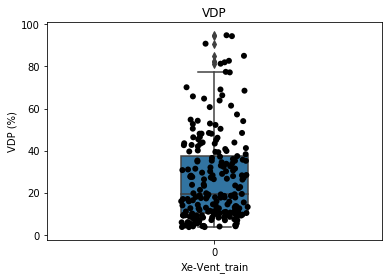

In [107]:
Xe_VDP_train = [x for x in Xe_VDP_train if str(x) != 'nan']
        
mean_dice =np.mean(Xe_VDP_train)
sd_dice=np.std(Xe_VDP_train)

print(mean_dice, sd_dice)

print(len(Xe_VDP_train))

18.386309992262884 10.600951453568449
30


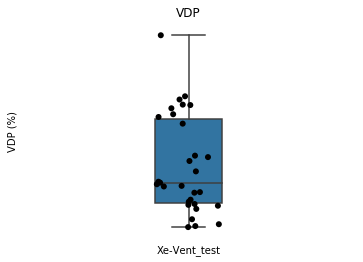

In [18]:
Xe_VDP_test = [x for x in Xe_VDP_test if str(x) != 'nan']
        
mean_dice =np.mean(Xe_VDP_test)
sd_dice=np.std(Xe_VDP_test)

print(mean_dice, sd_dice)

print(len(Xe_VDP_test))

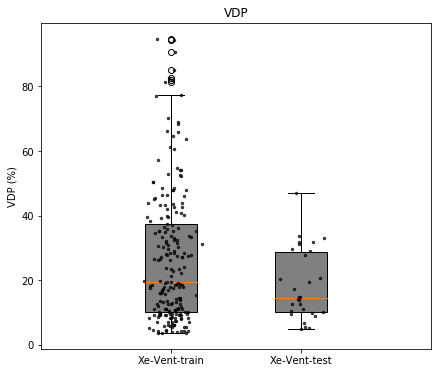

In [26]:
fig, ax = plt.subplots(figsize=(7,6))

# Set the positions for the boxplots
positions = [0, .5]

# Plot DL_VDP boxplot
ax.boxplot(Xe_VDP_train, positions=[positions[0]], widths=0.2, patch_artist=True, boxprops=dict(facecolor='gray'))

# Plot DL_VDP data points
dl_positions = np.random.normal(positions[0], 0.04, size=len(Xe_VDP_train))
ax.scatter(dl_positions, Xe_VDP_train, color='black', s=6, alpha=0.7, zorder=10)

# Plot Xe_VDP boxplot
ax.boxplot(Xe_VDP_test, positions=[positions[1]], widths=0.2, patch_artist=True, boxprops=dict(facecolor='gray'))

# Plot Xe_VDP data points
xe_positions = np.random.normal(positions[1], 0.04, size=len(Xe_VDP_test))
ax.scatter(xe_positions, Xe_VDP_test, color='black', s=6, alpha=0.7, zorder=10)

# Set x-axis tick labels
ax.set_xticks(positions)
ax.set_xticklabels(['Xe-Vent-train', 'Xe-Vent-test'])

# Set title and labels
ax.set_title('VDP')
ax.set_ylabel('VDP (%)')
plt.savefig("/mnt/nas203/forGPU/leesangy/dpi_normal_graph.png", dpi=1200, bbox_inches='tight', pad_inches = 0)
# Show the plot
plt.show()

In [28]:
from PIL import Image
png_image = Image.open('/mnt/nas203/forGPU/leesangy/Xe_vent train vs. test VDP.png')
dpi=1200
png_image.save('/mnt/nas203/forGPU/leesangy/Xe_vent train vs. test VDP.tiff', format='tiff', dpi = (1200,1200))

In [17]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(Xe_VDP_test, Xe_VDP_train)

print("mannwhitneyu test p-value:", p_value)

mannwhitneyu test p-value: 0.11035942226823728


In [22]:
from scipy.stats import shapiro

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(Xe_VDP_train)

# Print the test statistic and p-value
print("Train Shapiro-Wilk test statistic:", statistic)
print("train, p-value:", p_value)

statistic, p_value = shapiro(Xe_VDP)

# Print the test statistic and p-value
print("Test Shapiro-Wilk test statistic:", statistic)
print("test, p-value:", p_value)

#suggesting that they follow normal distribution

Train Shapiro-Wilk test statistic: 0.8810071349143982
train, p-value: 6.611741536211024e-12
Test Shapiro-Wilk test statistic: 0.8969082236289978
test, p-value: 0.0060397787019610405


In [16]:
test_data_dir = "/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/final_inference/multitasking_G_256/test22/nifti/*.nii.gz"
test_data_list = list_sort_nicely(glob.glob(test_data_dir))
print(len(test_data_list))

DL_VDP = []
per_patient_vdp = []
patient = "none"
start_time = time.time()

for i in range(len(test_data_list)):
    test_data = test_data_list[i]
    
    if test_data[-19:-16] != patient:
        patient = test_data[-19:-16]
        DL_VDP.append(np.mean(per_patient_vdp))
        per_patient_vdp = []
        #print(DL_VDP)
        
    test_file = nib.load(test_data)
    test_data = np.rot90(test_file.get_fdata().squeeze(), k=3)
    test_copied = test_data.copy()
    test_background_mask = (test_data != 0)
    
    lung_surface = np.count_nonzero(test_background_mask)
    
    test_copied[(test_copied > 0) & (test_copied < centers[0])] = 2
    test_copied[(test_copied >= centers[0]) & (test_copied <= 1)] = 0
    test_copied[test_copied ==2]= 1
    
    #plt.imshow(test_copied)
    #plt.show()
    
    defect_surface = np.count_nonzero(test_copied)
    vdp_percentage = defect_surface / lung_surface *100
    
    #print(vdp_percentage)
    per_patient_vdp.append(vdp_percentage)
    
    if i ==5999:
        print(i)
        DL_VDP.append(np.mean(per_patient_vdp))
    
    if i % 500 == 0:
        print(i, (time.time()-start_time)/60, "min")
        

6000
0 0.0005698641141255697 min


/home/danny7454/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/danny7454/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


500 0.22330467303593954 min
1000 0.45007556676864624 min
1500 0.6527638514836629 min
2000 0.8790794491767884 min
2500 1.1094561258951823 min
3000 1.37584441502889 min
3500 1.613408629099528 min
4000 1.8353317658106485 min
4500 2.4707682450612385 min
5000 2.696156406402588 min
5500 2.938727442423503 min
5999


In [25]:
from scipy.stats import shapiro

DL_VDP = [x for x in DL_VDP if str(x) != 'nan']
        
mean_dice =np.mean(DL_VDP)
sd_dice=np.std(DL_VDP)

print(mean_dice, sd_dice)

print(len(DL_VDP))

statistic, p_value = shapiro(DL_VDP)

# Print the test statistic and p-value
print("Shapiro-Wilk test statistic:", statistic)
print("train, p-value:", p_value)

20.360988537696297 13.166805488553937
30
Shapiro-Wilk test statistic: 0.8779579997062683
train, p-value: 0.0025315287057310343


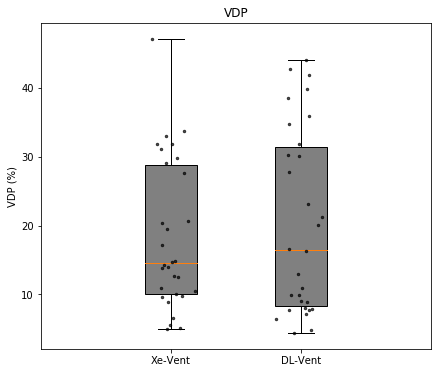

In [28]:
plt.rcParams.update({
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True
})

fig, ax = plt.subplots(figsize=(7,6))

# Set the positions for the boxplots
positions = [.5, 0]

# Plot DL_VDP boxplot
ax.boxplot(DL_VDP, positions=[positions[0]], widths=0.2, patch_artist=True, boxprops=dict(facecolor='gray'))
dl_positions = np.random.normal(positions[0], 0.04, size=len(DL_VDP))
ax.scatter(dl_positions, DL_VDP, color='black', s=6, alpha=0.7, zorder=10)

# Plot Xe_VDP boxplot
ax.boxplot(Xe_VDP_test, positions=[positions[1]], widths=0.2, patch_artist=True, boxprops=dict(facecolor='gray'))
xe_positions = np.random.normal(positions[1], 0.04, size=len(Xe_VDP_test))
ax.scatter(xe_positions, Xe_VDP_test, color='black', s=6, alpha=0.7, zorder=10)

# Set x-axis tick labels
ax.set_xticks(positions)
ax.set_xticklabels(['DL-Vent', 'Xe-Vent'])

# Set title and labels
ax.set_title('VDP')
ax.set_ylabel('VDP (%)')
plt.savefig("/mnt/nas203/forGPU/leesangy/Xe_vent VDP vs. DL_vent VDP.png", dpi=1200, bbox_inches='tight', pad_inches = 0)
# Show the plot
plt.show()


In [52]:
png_image = Image.open('/mnt/nas203/forGPU/leesangy/Xe_vent VDP vs. DL_vent VDP.png')
dpi=1200
png_image.save('/mnt/nas203/forGPU/leesangy/Xe_vent VDP vs. DL_vent VDP.tiff', format='tiff', dpi = (1200,1200))

import scipy.stats as stats
import statsmodels.stats.multitest as multi

# Perform Wilcoxon signed-rank test
statistic, p_value = stats.wilcoxon(Xe_VDP_test, DL_VDP)

print("Wilcoxon signed-rank test p-value:", p_value)

Wilcoxon signed-rank test p-value: 0.7655192919016102


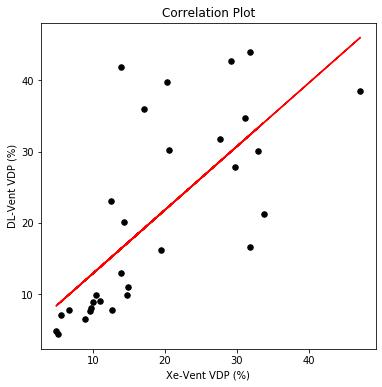

correlation: 0.8211345939933259
slope: 0.8921935459222314
intercept: 3.9568414292739185
P value 2.7131748359304468e-08


In [13]:
import scipy.stats as stats

x=Xe_VDP_test
y=DL_VDP

correlation, p_value = stats.spearmanr(x, y)

# Perform linear regression
slope, intercept, _, _, _ = stats.linregress(x, y)

# Generate regression line
regression_line = slope * np.array(x) + intercept

# Plot the data points and regression line
plt.figure(figsize=(6,6))
plt.scatter(x,y, color='black', label='Data', s=30)
plt.plot(x, regression_line, color='red', label='Regression Line')

# Set labels and title
plt.xlabel('Xe-Vent VDP (%)')
plt.ylabel('DL-Vent VDP (%)')
#plt.title('Correlation Plot')

# Display slope, intercept, and Spearman coefficient as text
#text = f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nSpearman Coefficient: {correlation:.2f}'
#plt.text(4, 47, text, fontsize=12, verticalalignment='top')

plt.savefig("/mnt/nas203/forGPU/leesangy/Xe_vent VDP vs. DL_vent VDP correlation.png", dpi=1200)
plt.show()

print("correlation:", correlation)
print("slope:", slope)
print("intercept:", intercept)
print("P value", p_value)

In [58]:
png_image = Image.open('/mnt/nas203/forGPU/leesangy/Xe_vent VDP vs. DL_vent VDP correlation.png')
dpi=1200
png_image.save('/mnt/nas203/forGPU/leesangy/Xe_vent VDP vs. DL_vent VDP correlation.tiff', format='tiff', dpi = (1200,1200))

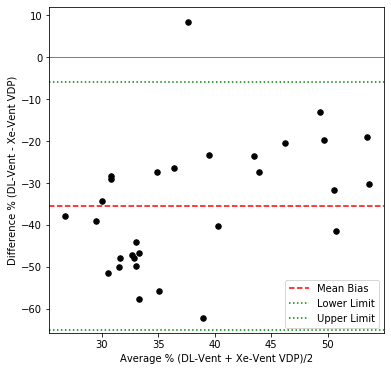

-35.4913051317707 15.101946929536842 -65.09112111366291 -5.891489149878492


In [109]:
differences = np.array(y) - np.array(x)
means = (np.array(x) + np.array(y)) / 2
#means = np.array(y)

# Calculate the mean bias, lower limit, and upper limit
mean_bias = np.mean(differences)
lower_limit = mean_bias - 1.96 * np.std(differences)  # 95% CI calculation
upper_limit = mean_bias + 1.96 * np.std(differences)
plt.figure(figsize=(6,6))
# Plot the Bland-Altman plot
plt.scatter(means, differences, color='black', s=30)
plt.axhline(mean_bias, color='red', linestyle='--', label='Mean Bias')
plt.axhline(lower_limit, color='green', linestyle=':', label='Lower Limit')
plt.axhline(upper_limit, color='green', linestyle=':', label='Upper Limit')
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.xlabel('Average % (DL-Vent + Xe-Vent VDP)/2')
plt.ylabel('Difference % (DL-Vent - Xe-Vent VDP)')
#plt.title('Bland-Altman Plot')
plt.legend()
#plt.savefig("/mnt/nas203/forGPU/leesangy/Xe_vent VDP vs. DL_vent VDP bland altman.png", dpi=1200)

# Display the mean difference and 95% CIs as text
#mean_diff_text = f'Mean Difference: {mean_bias:.2f}'
#ci_text = f'95% CIs: [{lower_limit:.2f}, {upper_limit:.2f}]'
#plt.text(np.mean(means), np.mean(differences), mean_diff_text, fontsize=12, verticalalignment='bottom')
#plt.text(np.mean(means), lower_limit, ci_text, fontsize=10, verticalalignment='top')
#plt.savefig("/mnt/nas203/forGPU/leesangy/final_inference/pix2pix_256/test22/bland-altman.png")
# Show the plot
plt.show()

mean_bias = np.mean(differences)
std_bias = np.std(differences)
lower_limit = mean_bias - 1.96 * np.std(differences)  # 95% CI calculation
upper_limit = mean_bias + 1.96 * np.std(differences)

print(mean_bias, std_bias, lower_limit, upper_limit)

In [110]:
png_image = Image.open('/mnt/nas203/forGPU/leesangy/Xe_vent VDP vs. DL_vent VDP bland altman.png')
dpi=1200
png_image.save('/mnt/nas203/forGPU/leesangy/Xe_vent VDP vs. DL_vent VDP bland altman.tiff', format='tiff', dpi = (1200,1200))

In [14]:
test_data_dir = "/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/final_inference/testset_gif/nifti/*.nii.gz"
test_data_list = list_sort_nicely(glob.glob(test_data_dir))
print(len(test_data_list))

test_output_dir = "/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/final_inference/multitasking_G_256/test22/nifti/*.nii.gz"
test_output_list = list_sort_nicely(glob.glob(test_output_dir))
print(len(test_output_list))

print(test_data_list[0][-27:-24])

6000
6000
008


In [17]:
#Ventilation defects dice

import time

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    sum_pixels = np.sum(y_true) + np.sum(y_pred)
    dice = 2.0 * intersection / sum_pixels if sum_pixels > 0 else 0.0
    return dice

patient = "none"
Dice_list = []
per_patient_dice = []
start_time = time.time()
centers = [0.20207, 0.38160, 0.56472]

def has_ones(image_array):
    for row in image_array:
        if 1 in row:
            return True
    return False

for i in range(len(test_data_list)):
    test_data = test_data_list[i]
    if test_data[-27:-24] != patient:
        patient = test_data[-27:-24]
        Dice_list.append(np.mean(per_patient_dice))
        per_patient_dice = []
        #print(Dice_list)
    
    test_file = nib.load(test_data)
    test_data = np.rot90(test_file.get_fdata().squeeze(), k=3)
    test_copied = test_data.copy()
    test_background_mask = (test_data != 0)
    test_copied[(test_copied > 0) & (test_copied < centers[0])] = 2
    test_copied[(test_copied >= centers[0]) & (test_copied <= 1)] = 0
    test_copied[test_copied ==2]= 1
    
    test_output = test_output_list[i]
    test_output = nib.load(test_output)
    test_output_data = np.rot90(np.rot90(np.rot90(test_output.get_fdata().squeeze(), k=3),k=3),k=3)
    test_output_copied = test_output_data.copy()
    test_output_copied = test_output_copied * test_background_mask
    test_output_copied[(test_output_copied > 0) & (test_output_copied < centers[0])] = 2
    test_output_copied[(test_output_copied >= centers[0]) & (test_output_copied <= 1)] = 0
    test_output_copied[test_output_copied==2]=1
    
    dice = dice_coefficient(test_copied, test_output_copied)*100
    if has_ones(test_copied) == False and has_ones(test_output_copied) == False:
        dice = 100
    per_patient_dice.append(dice)
    
    if i ==5999:
        print(i)
        Dice_list.append(np.mean(per_patient_dice))
    
    if i % 500 == 0:
        print(i, (time.time()-start_time)/60, "min")

0 0.001166832447052002 min
500 0.7004475871721904 min
1000 1.0285882790883383 min
1500 1.385950231552124 min
2000 1.7596139709154766 min
2500 2.0628679990768433 min
3000 2.3365230679512026 min
3500 2.716923248767853 min
4000 3.141487101713816 min
4500 4.056855511665344 min
5000 4.383727125326792 min
5500 4.748579188187917 min
5999


In [72]:
#Ventilation dice

patient = "none"
ventilation_Dice_list = []
per_patient_dice = []
start_time = time.time()
centers = [0.20207, 0.38160, 0.56472]

def has_ones(image_array):
    for row in image_array:
        if 1 in row:
            return True
    return False

for i in range(len(test_data_list)):
    test_data = test_data_list[i]
    if test_data[-27:-24] != patient:
        patient = test_data[-27:-24]
        ventilation_Dice_list.append(np.mean(per_patient_dice))
        per_patient_dice = []
        #print(Dice_list)
    
    test_file = nib.load(test_data)
    test_data = np.rot90(test_file.get_fdata().squeeze(), k=3)
    test_copied = test_data.copy()
    test_background_mask = (test_data != 0)
    test_copied[(test_copied > 0) & (test_copied < centers[0])] = 0
    test_copied[(test_copied >= centers[0]) & (test_copied <= 1)] = 2
    test_copied[test_copied ==2]= 1
    
    test_output = test_output_list[i]
    test_output = nib.load(test_output)
    test_output_data = np.rot90(np.rot90(np.rot90(test_output.get_fdata().squeeze(), k=3),k=3),k=3)
    test_output_copied = test_output_data.copy()
    test_output_copied = test_output_copied * test_background_mask
    test_output_copied[(test_output_copied > 0) & (test_output_copied < centers[0])] = 0
    test_output_copied[(test_output_copied >= centers[0]) & (test_output_copied <= 1)] = 2
    test_output_copied[test_output_copied==2]=1
    
    dice = dice_coefficient(test_copied, test_output_copied)*100
    if has_ones(test_copied) == False and has_ones(test_output_copied) == False:
        dice = 100
    per_patient_dice.append(dice)
    
    if i ==5999:
        print(i)
        ventilation_Dice_list.append(np.mean(per_patient_dice))
    
    if i % 500 == 0:
        print(i, (time.time()-start_time)/60, "min")

0 0.007786409060160319 min
500 0.5957030296325684 min
1000 0.8430258870124817 min
1500 1.0748941421508789 min
2000 1.6137370864550273 min
2500 1.874949030081431 min
3000 2.1827955643335977 min
3500 2.8243848999341328 min
4000 3.082107337315877 min
4500 3.3319289247194925 min
5000 3.557260290781657 min
5500 4.02300994793574 min
5999


In [18]:
Dice_list = [x for x in Dice_list if str(x) != 'nan']
        
mean_dice =np.mean(Dice_list)
sd_dice=np.std(Dice_list)

print(mean_dice, sd_dice)

print(len(Dice_list))
print(len(DL_VDP))
print(len(Xe_VDP_test))

ventilation_Dice_list = [x for x in ventilation_Dice_list if str(x) != 'nan']
        
mean_dice =np.mean(ventilation_Dice_list)
sd_dice=np.std(ventilation_Dice_list)

print(mean_dice, sd_dice)

print(len(ventilation_Dice_list))
print(len(DL_VDP))
print(len(Xe_VDP_test))

55.852293669466995 8.127197330162021
30
30
30


NameError: name 'ventilation_Dice_list' is not defined

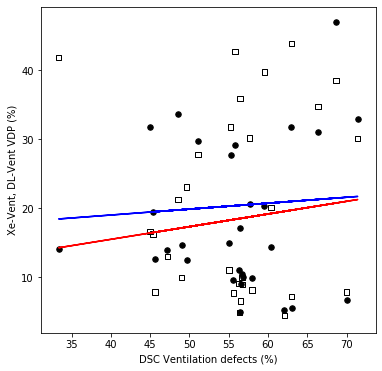

-0.058954393770856504 0.7569754726974458
-0.00867630700778643 0.9637059421012134
slope1: 0.18392158487865684
y intercept 1: 8.113867621466342
slope2: 0.08589759696977821
y intercept 2: 15.563410726238725
P value: 2.7131748359304468e-08


In [19]:
import scipy.stats as stats
import statsmodels.stats.multitest as multi

x=Dice_list
y1=Xe_VDP_test
y2=DL_VDP

correlation1, p_value1 = stats.spearmanr(x, y1)
correlation2, p_value2 = stats.spearmanr(x, y2)
# Perform linear regression
slope1, intercept1, _, _, _ = stats.linregress(x, y1)
slope2, intercept2, _, _, _ = stats.linregress(x, y2)
# Generate regression line
regression_line1 = slope1 * np.array(x) + intercept1
regression_line2 = slope2 * np.array(x) + intercept2

# Plot the data points and regression line
plt.figure(figsize=(6,6))
plt.axis('on')
plt.scatter(x,y1, color='black', label='Xe_VDP Data', marker='o', s=30)
plt.plot(x, regression_line1, color='red',  label='Xe Regression Line')
plt.scatter(x,y2, color='black', label='DL_VDP Data',marker='s', s=30, facecolors='none')
plt.plot(x, regression_line2, color='blue', label='DL-VDP Regression Line')


# Set labels and title
plt.xlabel('DSC Ventilation defects (%)')
plt.ylabel('Xe-Vent, DL-Vent VDP (%)')
#plt.title('Correlation Plot')

#plt.savefig("/mnt/nas203/forGPU/leesangy/DSC Ventilation defects vs. Xe-Vent, DL-Vent VDP.png", dpi=1200)
#png_image = Image.open('/mnt/nas203/forGPU/leesangy/DSC Ventilation defects vs. Xe-Vent, DL-Vent VDP.png')
#dpi=1200
#png_image.save('/mnt/nas203/forGPU/leesangy/DSC Ventilation defects vs. Xe-Vent, DL-Vent VDP.tiff', format='tiff', dpi = (1200,1200))
plt.show()

print(correlation1, p_value1)
print(correlation2, p_value2)
print("slope1:", slope1)
print("y intercept 1:", intercept1)
print("slope2:", slope2)
print("y intercept 2:", intercept2)

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Read the Excel file into a pandas DataFrame
df = pd.read_excel("/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/manuscript/pft_test_set(30).xlsx", header=None)
PFT = df.iloc[0].to_list()
pft_1 = PFT[1]  # Replace with the actual column names in your Excel file
pft_2 = PFT[2] 
pft_3 = PFT[3] 
pft_4 = PFT[4] 
pft_5 = PFT[5] 
pft_6 = PFT[6] 
pft_7 = PFT[7] 
# Read the Excel file into a pandas DataFrame
df = pd.read_excel("/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/manuscript/pft_test_set(30).xlsx")

column_index_1 = df.columns.get_loc(pft_1)
column_index_2 = df.columns.get_loc(pft_2)
column_index_3 = df.columns.get_loc(pft_3)
column_index_4 = df.columns.get_loc(pft_4)
column_index_5 = df.columns.get_loc(pft_5)
column_index_6 = df.columns.get_loc(pft_6)
column_index_7 = df.columns.get_loc(pft_7)

# Extract values for category "A"
FEV1_pred = df.iloc[:, column_index_1].tolist()
FVC_pred = df.iloc[:, column_index_2].tolist()
FEV1_FVC = df.iloc[:, column_index_3].tolist()
FEF25_75_pred = df.iloc[:, column_index_4].tolist()
DLCO_pred = df.iloc[:, column_index_5].tolist()
DLCO_VA_pred = df.iloc[:, column_index_6].tolist()
DL_Hb_pred = df.iloc[:, column_index_7].tolist()

DLCO_pred = [x for x in DLCO_pred if not math.isnan(x)]
DLCO_VA_pred = [x for x in DLCO_VA_pred if not math.isnan(x)]
DL_Hb_pred = [x for x in DL_Hb_pred if not math.isnan(x)]


print("FEV1_pred:", np.mean(FEV1_pred), np.std(FEV1_pred))
print("FVC_pred:", np.mean(FVC_pred), np.std(FVC_pred))
print("FEV1_FVC:", np.mean(FEV1_FVC), np.std(FEV1_FVC))
print("FEF25_75_pred:", np.mean(FEF25_75_pred), np.std(FEF25_75_pred))
print("DLCO_pred:", np.mean(DLCO_pred), np.std(DLCO_pred))
print("DLCO_VA_pred:", np.mean(DLCO_VA_pred), np.std(DLCO_VA_pred))
print("DL_Hb_pred:", np.mean(DL_Hb_pred), np.std(DL_Hb_pred))

FEV1_pred: 45.13333333333333 18.711375031128938
FVC_pred: 81.93333333333334 14.106578449629644
FEV1_FVC: 38.833333333333336 12.524864159831123
FEF25_75_pred: 17.766666666666666 11.377414273707165
DLCO_pred: 55.285714285714285 19.28888862764768
DLCO_VA_pred: 68.39285714285714 22.713022202054493
DL_Hb_pred: 55.535714285714285 19.402654720529394


P value Xe_VDP: 0.015211631967029097
P value DL_VDP: 0.3752280585103325


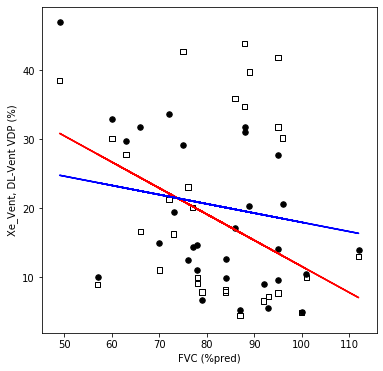

P-value: 0.2724054125118607


In [52]:
x=FVC_pred
y1=Xe_VDP_test
y2=DL_VDP

correlation1, p_value1 = stats.spearmanr(x, y1)
correlation2, p_value2 = stats.spearmanr(x, y2)

print("P value Xe_VDP:", p_value1)
print("P value DL_VDP:", p_value2)

# Perform linear regression
slope1, intercept1, _, _, _ = stats.linregress(x, y1)
slope2, intercept2, _, _, _ = stats.linregress(x, y2)

# Generate regression line
regression_line1 = slope1 * np.array(x) + intercept1
regression_line2 = slope2 * np.array(x) + intercept2
# Plot the data points and regression line
plt.figure(figsize=(6,6))
plt.scatter(x,y1, color='black', label='Xe_VDP Data', marker='o', s=30)
plt.plot(x, regression_line1, color='red',  label='Xe Regression Line')
plt.scatter(x,y2, color='black', label='DL_VDP Data',marker='s', s=30, facecolors='none')
plt.plot(x, regression_line2, color='blue', label='DL Regression Line')

# Set labels and title
plt.xlabel('FVC (%pred)')
plt.ylabel('Xe_Vent, DL-Vent VDP (%)')
#plt.title('Correlation Plot')
#plt.legend(loc='upper right')

# Display slope, intercept, and Spearman coefficient as text
#text = f'FVC(%pred) vs. Xe_VDP\nSpearman Coefficient: {correlation1:.2f}'
#plt.text(56,46, text, fontsize=12, verticalalignment='top')
#text = f'FVC(%pred) vs. DL_VDP\nSpearman Coefficient: {correlation2:.2f}'
#plt.text(56,40, text, fontsize=12, verticalalignment='top')

# Add legend
#plt.legend()
#plt.savefig("/mnt/nas203/forGPU/leesangy/final_inference/multitasking_G_256/test22/DSC ventilation defects vs. DL-vent-vdp.png")
# Show the plot
plt.savefig("/mnt/nas203/forGPU/leesangy/FVC vs. Xe-Vent, DL-Vent VDP.png", dpi=1200, linewidth=2)
png_image = Image.open('/mnt/nas203/forGPU/leesangy/FVC vs. Xe-Vent, DL-Vent VDP.png')
dpi=1200
png_image.save('/mnt/nas203/forGPU/leesangy/FVC vs. Xe-Vent, DL-Vent VDP.tiff', format='tiff', dpi = (1200,1200))
plt.show()

z1 = np.arctanh(correlation1)
z2 = np.arctanh(correlation2)
n1 = len(y1)
n2 = len(y2)
se1 = 1 / np.sqrt(n1-3)
se2 = 1 / np.sqrt(n2-3)
from scipy.stats import t

# Calculate the test statistic
diff_z = z1 - z2
se_diff = np.sqrt(se1**2 + se2**2)
t_stat = diff_z / se_diff

# Calculate the p-value
df = n1 + n2 - 2
p_value = 2 * (1 - t.cdf(abs(t_stat), df))
print("P-value:", p_value)

P value Xe_VDP: 0.0001480739207561741
P value DL_VDP: 1.5336231197489e-05
Xe_VDP_test correlation: -0.6381748344834421
DL_VDP correlation: -0.7020590959053983


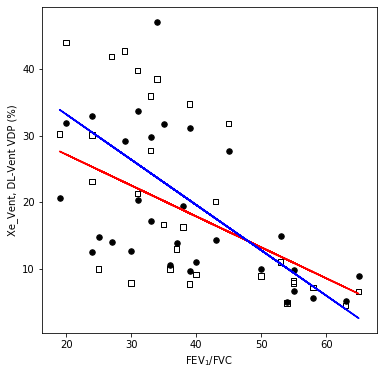

P-value: 0.6708370280676803


In [53]:
x=FEV1_FVC
y1=Xe_VDP_test
y2=DL_VDP

line_type = {'-' : '-', ## 라인 유형
             '--' : '--',
             '-.' : '-.',
             ':' : ':', '.' : '.   .   .   .'}

correlation1, p_value1 = stats.spearmanr(x, y1)
correlation2, p_value2 = stats.spearmanr(x, y2)

print("P value Xe_VDP:", p_value1)
print("P value DL_VDP:", p_value2)
print("Xe_VDP_test correlation:", correlation1)
print("DL_VDP correlation:", correlation2)

# Perform linear regression
slope1, intercept1, _, _, _ = stats.linregress(x, y1)
slope2, intercept2, _, _, _ = stats.linregress(x, y2)

# Generate regression line
regression_line1 = slope1 * np.array(x) + intercept1
regression_line2 = slope2 * np.array(x) + intercept2
# Plot the data points and regression line
plt.figure(figsize=(6,6))
plt.scatter(x,y1, color='black', label='Xe_VDP Data', marker='o', s=30)
plt.plot(x, regression_line1, color='red',  label='Xe Regression Line')
plt.scatter(x,y2, color='black', label='DL_VDP Data',marker='s', s=30, facecolors='none')
plt.plot(x, regression_line2, color='blue', label='DL Regression Line')

# Set labels and title
plt.xlabel('FEV$_{1}$/FVC')
plt.ylabel('Xe_Vent, DL-Vent VDP (%)')
#plt.title('Correlation Plot')
#plt.legend(loc='upper right')

# Display slope, intercept, and Spearman coefficient as text
text = f'FEV1/FVC(%pred) vs. Xe_VDP\nSpearman Coefficient: {correlation1:.2f}'
#plt.text(55,36, text, fontsize=12, verticalalignment='top')
text = f'FEV1/FVC(%pred) vs. DL_VDP\nSpearman Coefficient: {correlation2:.2f}'
#plt.text(55,30, text, fontsize=12, verticalalignment='top')

# Add legend
#plt.legend()
#plt.savefig("/mnt/nas203/forGPU/leesangy/final_inference/multitasking_G_256/test22/DSC ventilation defects vs. DL-vent-vdp.png")
# Show the plot
plt.savefig("/mnt/nas203/forGPU/leesangy/FEV1_FVC vs. Xe-Vent, DL-Vent VDP.png", dpi=1200, linewidth=2)
png_image = Image.open('/mnt/nas203/forGPU/leesangy/FEV1_FVC vs. Xe-Vent, DL-Vent VDP.png')
dpi=1200
png_image.save('/mnt/nas203/forGPU/leesangy/FEV1_FVC vs. Xe-Vent, DL-Vent VDP.tiff', format='tiff', dpi = (1200,1200))
plt.show()

z1 = np.arctanh(correlation1)
z2 = np.arctanh(correlation2)
n1 = len(y1)
n2 = len(y2)
se1 = 1 / np.sqrt(n1-3)
se2 = 1 / np.sqrt(n2-3)
from scipy.stats import t

# Calculate the test statistic
diff_z = z1 - z2
se_diff = np.sqrt(se1**2 + se2**2)
t_stat = diff_z / se_diff

# Calculate the p-value
df = n1 + n2 - 2
p_value = 2 * (1 - t.cdf(abs(t_stat), df))
print("P-value:", p_value)

P value Xe_VDP: 1.9433521850657933e-06
P value DL_VDP: 1.5785399831146374e-05
Xe_VDP_test correlation: -0.748775519947664
DL_VDP correlation: -0.701336737749909


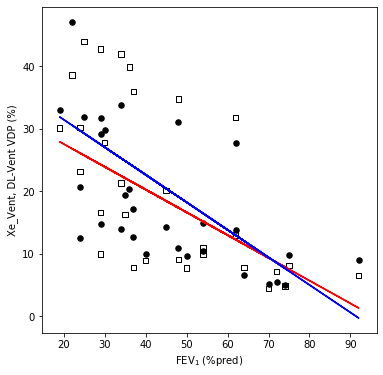

P-value: 0.7139981649042366


In [54]:
x=FEV1_pred
y1=Xe_VDP_test
y2=DL_VDP

correlation1, p_value1 = stats.spearmanr(x, y1)
correlation2, p_value2 = stats.spearmanr(x, y2)

print("P value Xe_VDP:", p_value1)
print("P value DL_VDP:", p_value2)
print("Xe_VDP_test correlation:", correlation1)
print("DL_VDP correlation:", correlation2)

# Perform linear regression
slope1, intercept1, _, _, _ = stats.linregress(x, y1)
slope2, intercept2, _, _, _ = stats.linregress(x, y2)

# Generate regression line
regression_line1 = slope1 * np.array(x) + intercept1
regression_line2 = slope2 * np.array(x) + intercept2
# Plot the data points and regression line
plt.figure(figsize=(6,6))
plt.scatter(x,y1, color='black', label='Xe_VDP Data', marker='o', s=30)
plt.plot(x, regression_line1, color='red',  label='Xe Regression Line')
plt.scatter(x,y2, color='black', label='DL_VDP Data',marker='s', s=30, facecolors='none')
plt.plot(x, regression_line2, color='blue',  label='DL Regression Line')

# Set labels and title
#plt.xlabel('FEV1 (%pred)')
plt.xlabel('FEV$_{1}$ (%pred)')
plt.ylabel('Xe_Vent, DL-Vent VDP (%)')
#plt.title('Correlation Plot')
#plt.legend(loc='upper right')

# Display slope, intercept, and Spearman coefficient as text
#text = f'FEV1(%pred) vs. Xe_VDP\nSpearman Coefficient: {correlation1:.2f}'
#plt.text(72,36, text, fontsize=12, verticalalignment='top')
#text = f'FEV1(%pred) vs. DL_VDP\nSpearman Coefficient: {correlation2:.2f}'
#plt.text(72,30, text, fontsize=12, verticalalignment='top')

# Add legend
#plt.legend()
#plt.savefig("/mnt/nas203/forGPU/leesangy/final_inference/multitasking_G_256/test22/DSC ventilation defects vs. DL-vent-vdp.png")
# Show the plot
plt.savefig("/mnt/nas203/forGPU/leesangy/FEV1 vs. Xe-Vent, DL-Vent VDP.png", dpi=1200, linewidth=2)
png_image = Image.open('/mnt/nas203/forGPU/leesangy/FEV1 vs. Xe-Vent, DL-Vent VDP.png')
dpi=1200
png_image.save('/mnt/nas203/forGPU/leesangy/FEV1 vs. Xe-Vent, DL-Vent VDP.tiff', format='tiff', dpi = (1200,1200))
plt.show()

z1 = np.arctanh(correlation1)
z2 = np.arctanh(correlation2)
n1 = len(y1)
n2 = len(y2)
se1 = 1 / np.sqrt(n1-3)
se2 = 1 / np.sqrt(n2-3)
from scipy.stats import t

# Calculate the test statistic
diff_z = z1 - z2
se_diff = np.sqrt(se1**2 + se2**2)
t_stat = diff_z / se_diff

# Calculate the p-value
df = n1 + n2 - 2
p_value = 2 * (1 - t.cdf(abs(t_stat), df))
print("P-value:", p_value)

P value Xe_VDP: 0.0004786214966209617
P value DL_VDP: 0.0006355922485428524
Xe_VDP_test correlation: -0.5983291529801096
DL_VDP correlation: -0.5878438919099884


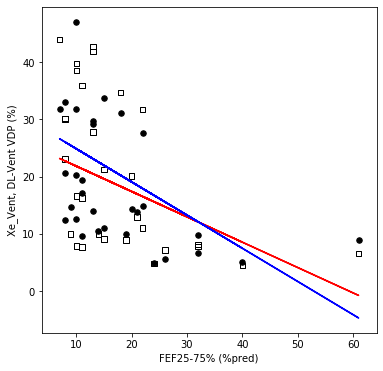

P-value: 0.9528119164948095


In [55]:
x=FEF25_75_pred
y1=Xe_VDP_test
y2=DL_VDP

correlation1, p_value1 = stats.spearmanr(x, y1)
correlation2, p_value2 = stats.spearmanr(x, y2)

print("P value Xe_VDP:", p_value1)
print("P value DL_VDP:", p_value2)
print("Xe_VDP_test correlation:", correlation1)
print("DL_VDP correlation:", correlation2)

# Perform linear regression
slope1, intercept1, _, _, _ = stats.linregress(x, y1)
slope2, intercept2, _, _, _ = stats.linregress(x, y2)

# Generate regression line
regression_line1 = slope1 * np.array(x) + intercept1
regression_line2 = slope2 * np.array(x) + intercept2
# Plot the data points and regression line
plt.figure(figsize=(6,6))
plt.scatter(x,y1, color='black', label='Xe_VDP Data', marker='o', s=30)
plt.plot(x, regression_line1, color='red',  label='Xe Regression Line')
plt.scatter(x,y2, color='black', label='DL_VDP Data',marker='s', s=30, facecolors='none')
plt.plot(x, regression_line2, color='blue', label='DL Regression Line')

# Set labels and title
plt.xlabel('FEF25-75% (%pred)')
plt.ylabel('Xe_Vent, DL-Vent VDP (%)')
#plt.title('Correlation Plot')
#plt.legend(loc='upper right')

# Display slope, intercept, and Spearman coefficient as text
#text = f'FEF25-75%) vs. Xe_VDP\nSpearman Coefficient: {correlation1:.2f}'
#plt.text(46,36, text, fontsize=12, verticalalignment='top')
#text = f'FEF25-75% vs. DL_VDP\nSpearman Coefficient: {correlation2:.2f}'
#plt.text(46,30, text, fontsize=12, verticalalignment='top')

plt.savefig("/mnt/nas203/forGPU/leesangy/FEF25-75 vs. Xe-Vent, DL-Vent VDP.png", dpi=1200, linewidth=2)
png_image = Image.open('/mnt/nas203/forGPU/leesangy/FEF25-75 vs. Xe-Vent, DL-Vent VDP.png')
dpi=1200
png_image.save('/mnt/nas203/forGPU/leesangy/FEF25-75 vs. Xe-Vent, DL-Vent VDP.tiff', format='tiff', dpi = (1200,1200))
plt.show()

z1 = np.arctanh(correlation1)
z2 = np.arctanh(correlation2)
n1 = len(y1)
n2 = len(y2)
se1 = 1 / np.sqrt(n1-3)
se2 = 1 / np.sqrt(n2-3)
from scipy.stats import t

# Calculate the test statistic
diff_z = z1 - z2
se_diff = np.sqrt(se1**2 + se2**2)
t_stat = diff_z / se_diff

# Calculate the p-value
df = n1 + n2 - 2
p_value = 2 * (1 - t.cdf(abs(t_stat), df))
print("P-value:", p_value)

In [44]:
Xe_VDP_partial=Xe_VDP_test.copy()
DL_VDP_partial=DL_VDP.copy()

In [45]:
del Xe_VDP_partial[14]
del Xe_VDP_partial[27]
del DL_VDP_partial[14]
del DL_VDP_partial[27]

28
P value Xe_VDP: 3.0418272627389593e-05
P value DL_VDP: 8.527373993859715e-07
Xe_VDP_test correlation: -0.7028213821569244
DL_VDP correlation: -0.7827994973517107


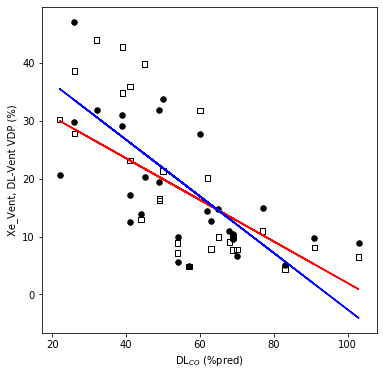

P-value: 0.5278804857565103


In [56]:
DLCO_pred = [x for x in DLCO_pred if not math.isnan(x)]

print(len(DLCO_pred))

x=DLCO_pred
y1=Xe_VDP_partial
y2=DL_VDP_partial



correlation1, p_value1 = stats.spearmanr(x, y1)
correlation2, p_value2 = stats.spearmanr(x, y2)

print("P value Xe_VDP:", p_value1)
print("P value DL_VDP:", p_value2)
print("Xe_VDP_test correlation:", correlation1)
print("DL_VDP correlation:", correlation2)

# Perform linear regression
slope1, intercept1, _, _, _ = stats.linregress(x, y1)
slope2, intercept2, _, _, _ = stats.linregress(x, y2)

# Generate regression line
regression_line1 = slope1 * np.array(x) + intercept1
regression_line2 = slope2 * np.array(x) + intercept2
# Plot the data points and regression line
plt.figure(figsize=(6,6))
plt.scatter(x,y1, color='black', label='Xe_VDP Data', marker='o', s=30)
plt.plot(x, regression_line1, color='red',  label='Xe Regression Line')
plt.scatter(x,y2, color='black', label='DL_VDP Data',marker='s', s=30, facecolors='none')
plt.plot(x, regression_line2, color='blue', label='DL Regression Line')

# Set labels and title
plt.xlabel('DL$_{CO}$ (%pred)')
#plt.xlabel('FEV$_{1}$ (%pred)')
plt.ylabel('Xe_Vent, DL-Vent VDP (%)')
#plt.legend(loc='upper right')

# Display slope, intercept, and Spearman coefficient as text
#text = f'DLCO(%pred) vs. Xe_VDP\nSpearman Coefficient: {correlation1:.2f}'
#plt.text(80,36, text, fontsize=12, verticalalignment='top')
#text = f'DLCO(%pred) vs. DL_VDP\nSpearman Coefficient: {correlation2:.2f}'
#plt.text(80,30, text, fontsize=12, verticalalignment='top')

plt.savefig("/mnt/nas203/forGPU/leesangy/DLCO vs. Xe-Vent, DL-Vent VDP.png", dpi=1200, linewidth=2)
png_image = Image.open('/mnt/nas203/forGPU/leesangy/DLCO vs. Xe-Vent, DL-Vent VDP.png')
dpi=1200
png_image.save('/mnt/nas203/forGPU/leesangy/DLCO vs. Xe-Vent, DL-Vent VDP.tiff', format='tiff', dpi = (1200,1200))
plt.show()

z1 = np.arctanh(correlation1)
z2 = np.arctanh(correlation2)
n1 = len(y1)
n2 = len(y2)
se1 = 1 / np.sqrt(n1-3)
se2 = 1 / np.sqrt(n2-3)
from scipy.stats import t

# Calculate the test statistic
diff_z = z1 - z2
se_diff = np.sqrt(se1**2 + se2**2)
t_stat = diff_z / se_diff

# Calculate the p-value
df = n1 + n2 - 2
p_value = 2 * (1 - t.cdf(abs(t_stat), df))
print("P-value:", p_value)

P value Xe_VDP: 0.0016659537603632534
P value DL_VDP: 9.118026963912462e-05
Xe_VDP_test correlation: -0.5666942477329214
DL_VDP correlation: -0.6715970495123844


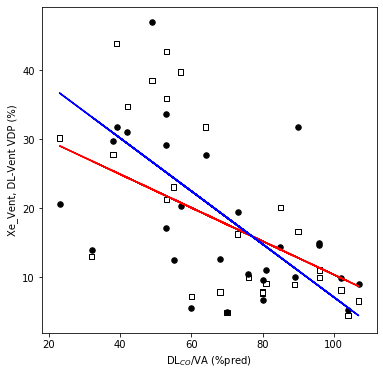

P-value: 0.54797635685703


In [57]:
#del DLCO_VA_pred[19]
DLCO_VA_pred = [x for x in DLCO_VA_pred if not math.isnan(x)]

x=DLCO_VA_pred
y1=Xe_VDP_partial
y2=DL_VDP_partial

correlation1, p_value1 = stats.spearmanr(x, y1)
correlation2, p_value2 = stats.spearmanr(x, y2)

print("P value Xe_VDP:", p_value1)
print("P value DL_VDP:", p_value2)
print("Xe_VDP_test correlation:", correlation1)
print("DL_VDP correlation:", correlation2)

# Perform linear regression
slope1, intercept1, _, _, _ = stats.linregress(x, y1)
slope2, intercept2, _, _, _ = stats.linregress(x, y2)

# Generate regression line
regression_line1 = slope1 * np.array(x) + intercept1
regression_line2 = slope2 * np.array(x) + intercept2
# Plot the data points and regression line
plt.figure(figsize=(6,6))
plt.scatter(x,y1, color='black', label='Xe_VDP Data', marker='o', s=30)
plt.plot(x, regression_line1, color='red',  label='Xe Regression Line')
plt.scatter(x,y2, color='black', label='DL_VDP Data',marker='s', s=30, facecolors='none')
plt.plot(x, regression_line2, color='blue',  label='DL Regression Line')

# Set labels and title
plt.xlabel('DL$_{CO}$/VA (%pred)')
plt.ylabel('Xe_Vent, DL-Vent VDP (%)')
#plt.legend(loc='upper right')

# Display slope, intercept, and Spearman coefficient as text
#text = f'DLCO/VA(%pred) vs. Xe_VDP\nSpearman Coefficient: {correlation1:.2f}'
#plt.text(93,36, text, fontsize=12, verticalalignment='top')
#text = f'DLCO/VA(%pred) vs. DL_VDP\nSpearman Coefficient: {correlation2:.2f}'
#plt.text(93,30, text, fontsize=12, verticalalignment='top')

plt.savefig("/mnt/nas203/forGPU/leesangy/DLCO_VA vs. Xe-Vent, DL-Vent VDP.png", dpi=1200, linewidth=2)
png_image = Image.open('/mnt/nas203/forGPU/leesangy/DLCO_VA vs. Xe-Vent, DL-Vent VDP.png')
dpi=1200
png_image.save('/mnt/nas203/forGPU/leesangy/DLCO_VA vs. Xe-Vent, DL-Vent VDP.tiff', format='tiff', dpi = (1200,1200))
plt.show()


z1 = np.arctanh(correlation1)
z2 = np.arctanh(correlation2)
n1 = len(y1)
n2 = len(y2)
se1 = 1 / np.sqrt(n1-3)
se2 = 1 / np.sqrt(n2-3)
from scipy.stats import t

# Calculate the test statistic
diff_z = z1 - z2
se_diff = np.sqrt(se1**2 + se2**2)
t_stat = diff_z / se_diff

# Calculate the p-value
df = n1 + n2 - 2
p_value = 2 * (1 - t.cdf(abs(t_stat), df))
print("P-value:", p_value)

P value Xe_VDP: 2.8411086253360302e-05
P value DL_VDP: 1.0215840326291892e-06
Xe_VDP_test correlation: -0.7046420931238419
DL_VDP correlation: -0.7794059063468535


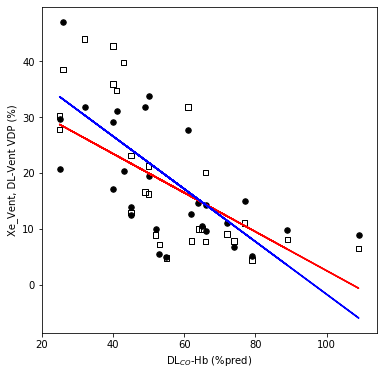

P-value: 0.5564362367405331


In [58]:
#del DL_Hb_pred[19]
DL_Hb_pred = [x for x in DL_Hb_pred if not math.isnan(x)]

x=DL_Hb_pred
y1=Xe_VDP_partial
y2=DL_VDP_partial

correlation1, p_value1 = stats.spearmanr(x, y1)
correlation2, p_value2 = stats.spearmanr(x, y2)

print("P value Xe_VDP:", p_value1)
print("P value DL_VDP:", p_value2)
print("Xe_VDP_test correlation:", correlation1)
print("DL_VDP correlation:", correlation2)

# Perform linear regression
slope1, intercept1, _, _, _ = stats.linregress(x, y1)
slope2, intercept2, _, _, _ = stats.linregress(x, y2)

# Generate regression line
regression_line1 = slope1 * np.array(x) + intercept1
regression_line2 = slope2 * np.array(x) + intercept2
# Plot the data points and regression line
plt.figure(figsize=(6,6))
plt.scatter(x,y1, color='black', label='Xe_VDP Data', marker='o', s=30)
plt.plot(x, regression_line1, color='red',  label='Xe Regression Line')
plt.scatter(x,y2, color='black', label='DL_VDP Data',marker='s', s=30, facecolors='none')
plt.plot(x, regression_line2, color='blue',  label='DL Regression Line')

# Set labels and title
plt.xlabel('DL$_{CO}$-Hb (%pred)')
plt.ylabel('Xe_Vent, DL-Vent VDP (%)')
#plt.legend(loc='upper right')

# Display slope, intercept, and Spearman coefficient as text
#text = f'DLCO-Hb(%pred) vs. Xe_VDP\nSpearman Coefficient: {correlation1:.2f}'
#plt.text(85,36, text, fontsize=12, verticalalignment='top')
#text = f'DLCO-Hb(%pred) vs. DL_VDP\nSpearman Coefficient: {correlation2:.2f}'
#plt.text(85,30, text, fontsize=12, verticalalignment='top')

plt.savefig("/mnt/nas203/forGPU/leesangy/DL_Hb vs. Xe-Vent, DL-Vent VDP.png", dpi=1200, linewidth=2)
png_image = Image.open('/mnt/nas203/forGPU/leesangy/DL_Hb vs. Xe-Vent, DL-Vent VDP.png')
dpi=1200
png_image.save('/mnt/nas203/forGPU/leesangy/DL_Hb vs. Xe-Vent, DL-Vent VDP.tiff', format='tiff', dpi = (1200,1200))
plt.show()

z1 = np.arctanh(correlation1)
z2 = np.arctanh(correlation2)
n1 = len(y1)
n2 = len(y2)
se1 = 1 / np.sqrt(n1-3)
se2 = 1 / np.sqrt(n2-3)
from scipy.stats import t

# Calculate the test statistic
diff_z = z1 - z2
se_diff = np.sqrt(se1**2 + se2**2)
t_stat = diff_z / se_diff

# Calculate the p-value
df = n1 + n2 - 2
p_value = 2 * (1 - t.cdf(abs(t_stat), df))
print("P-value:", p_value)

(256, 256)
(256, 256)


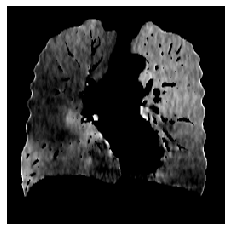

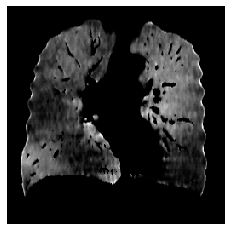

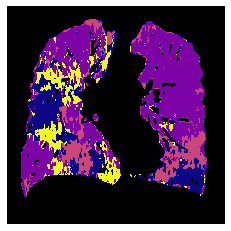

In [6]:
import nibabel as nib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.bottom': False,
    'axes.spines.left': False,
    'xtick.bottom': False,
    'xtick.labelbottom': False,
    'ytick.left': False,
    'ytick.labelleft': False
})

file_A = '/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/final_inference/testset_gif/nifti/164_0000_271_resized.nii.gz'
file_B = '/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/final_inference/multitasking_G_256/test22/nifti/164_0000_271.nii.gz'

    # Load NIfTI files
img_A = nib.load(file_A)
img_B = nib.load(file_B)

# Get data arrays
data_A = img_A.get_fdata()
data_A = np.rot90(data_A.squeeze(), k=3)
data_B = np.rot90(np.rot90(np.rot90(img_B.get_fdata(),k=3), k=3),k=3)

data_A = np.fliplr(data_A)
data_B = np.fliplr(data_B)

print(data_A.shape)
print(data_B.shape)

plt.imshow(data_A.squeeze(), cmap='gray')
plt.savefig("/mnt/nas203/forGPU/leesangy/164_0000_271_real.png", dpi=600, bbox_inches='tight', pad_inches = 0)
png_image = Image.open('/mnt/nas203/forGPU/leesangy/164_0000_271_real.png')
dpi=1200
png_image.save('/mnt/nas203/forGPU/leesangy/164_0000_271_real.tiff', format='tiff', dpi = (600,600))
plt.show()

plt.imshow(data_B.squeeze(), cmap='gray')
plt.savefig("/mnt/nas203/forGPU/leesangy/164_0000_271_dl.png", dpi=600, bbox_inches='tight', pad_inches = 0)
png_image = Image.open('/mnt/nas203/forGPU/leesangy/164_0000_271_dl.png')
dpi=1200
png_image.save('/mnt/nas203/forGPU/leesangy/164_0000_271_dl.tiff', format='tiff', dpi = (600,600))
plt.show()

# Threshold values for TP region
threshold = 0.202

# Create empty arrays for TP, TN, FP, FN
tp = np.zeros(data_A.shape)
tn = np.zeros(data_A.shape)
fp = np.zeros(data_A.shape)
fn = np.zeros(data_A.shape)

# Calculate TP, TN, FP, FN
tp[np.logical_and(data_A > 0, data_A < threshold, data_B < threshold)] = 1
tn[np.logical_and(data_A >= threshold, data_B >= threshold)] = 2
fp[np.logical_and(data_A >= threshold, data_B < threshold)] = 3
fn[np.logical_and(data_A < threshold, data_B >= threshold)] = 4

merged_data = tp + tn + fp + fn

cmap = plt.cm.get_cmap('plasma')
cmap.set_under('k')

# Plot the merged data

plt.rcParams.update({
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.bottom': False,
    'axes.spines.left': False,
    'xtick.bottom': False,
    'xtick.labelbottom': False,
    'ytick.left': False,
    'ytick.labelleft': False
})
plt.figure()
plt.imshow(merged_data.squeeze(), cmap=cmap, vmin=1)  # Set vmin to 1 to exclude the background value 0
plt.savefig("/mnt/nas203/forGPU/leesangy/164_0000_271_map.png", dpi=600, bbox_inches='tight', pad_inches = 0)
png_image = Image.open('/mnt/nas203/forGPU/leesangy/164_0000_271_map.png')
dpi=600
png_image.save('/mnt/nas203/forGPU/leesangy/164_0000_271_map.tiff', format='tiff', dpi = (600,600))
plt.show()

plt.rcParams.update({
    'axes.spines.top': True,
    'axes.spines.right': True,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True
})

In [ ]:
centers = [0.20207]

#test_data = "/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/final_inference/multitasking_G_256/test22/nifti/099_0000_205.nii.gz"
test_data = "/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/final_inference/testset_gif/nifti/099_0000_205_resized.nii.gz"
#print(glob.glob("/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/final_inference/multitasking_G_256/test22/*"))

#\\192.168.45.203\forGPU\leesangy\Task_VQ_mismatch\final_inference\multitasking_G_256\test22\nifti

test_file = nib.load(test_data)
test_data = np.rot90(test_file.get_fdata().squeeze(), k=3)
test_copied = test_data.copy()
test_background_mask = (test_data != 0)

lung_surface = np.count_nonzero(test_background_mask)

test_copied[(test_copied > 0) & (test_copied < centers[0])] = 2
test_copied[(test_copied >= centers[0]) & (test_copied <=1)] = 0
test_copied[test_copied ==2]= 1

#plt.imshow(test_copied)
#plt.show()

defect_surface = np.count_nonzero(test_copied)
vdp_percentage = defect_surface / lung_surface * 100

print(vdp_percentage)

In [16]:
from scipy.stats import chi2_contingency

# Define the observed contingency table
observed = [[22, 8],
            [182, 22]]

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(observed)

# Display the test results
print("Chi-square statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Expected frequencies:", expected)

Chi-square statistic: 4.567149653979238
p-value: 0.032590748523893376
Degrees of freedom: 1
Expected frequencies: [[ 26.15384615   3.84615385]
 [177.84615385  26.15384615]]


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

# Read the Excel file into a pandas DataFrame
df = pd.read_excel("/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/train, valid, test, PFT dataset/PFT_train.xlsx", header=None)
PFT = df.iloc[0].to_list()
pft_1 = PFT[1]  # Replace with the actual column names in your Excel file
pft_2 = PFT[2] 
pft_3 = PFT[3] 
pft_4 = PFT[4] 
pft_5 = PFT[5] 
pft_6 = PFT[6] 
pft_7 = PFT[7] 
# Read the Excel file into a pandas DataFrame
df = pd.read_excel("/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/train, valid, test, PFT dataset/PFT_train.xlsx")

column_index_1 = df.columns.get_loc(pft_1)
column_index_2 = df.columns.get_loc(pft_2)
column_index_3 = df.columns.get_loc(pft_3)
column_index_4 = df.columns.get_loc(pft_4)
column_index_5 = df.columns.get_loc(pft_5)
column_index_6 = df.columns.get_loc(pft_6)
column_index_7 = df.columns.get_loc(pft_7)

# Extract values for category "A"
FEV1_pred = df.iloc[:, column_index_1].tolist()
FVC_pred = df.iloc[:, column_index_2].tolist()
FEV1_FVC = df.iloc[:, column_index_3].tolist()
FEF25_75_pred = df.iloc[:, column_index_4].tolist()
DLCO_pred = df.iloc[:, column_index_5].tolist()
DLCO_VA_pred = df.iloc[:, column_index_6].tolist()
DL_Hb_pred = df.iloc[:, column_index_7].tolist()

FEV1_pred_train = [x for x in FEV1_pred if not math.isnan(x)]
FVC_pred_train = [x for x in FVC_pred if not math.isnan(x)]
FEV1_FVC_train = [x for x in FEV1_FVC if not math.isnan(x)]
FEF25_75_pred_train = [x for x in FEF25_75_pred if not math.isnan(x)]

DLCO_pred_train = [x for x in DLCO_pred if not math.isnan(x)]
DLCO_VA_pred_train = [x for x in DLCO_VA_pred if not math.isnan(x)]
DL_Hb_pred_train = [x for x in DL_Hb_pred if not math.isnan(x)]

from scipy.stats import shapiro

statistic, p_value = shapiro(FEV1_pred_train)
print(statistic, p_value)
statistic, p_value = shapiro(FEV1_FVC_train)
print(statistic, p_value)
statistic, p_value = shapiro(FEF25_75_pred_train)
print(statistic, p_value)
statistic, p_value = shapiro(DLCO_pred_train)
print(statistic, p_value)
statistic, p_value = shapiro(DLCO_VA_pred_train)
print(statistic, p_value)
statistic, p_value = shapiro(DL_Hb_pred_train)
print(statistic, p_value)

0.9586496353149414 9.169689292320982e-06
0.9552220106124878 3.9506116991105955e-06
0.6132413744926453 1.869289849721503e-21
0.966870903968811 9.968390077119693e-05
0.9803198575973511 0.0058622355572879314
0.9661138653755188 8.101917046587914e-05


In [4]:
print("FEV1_pred:", "#", len(FEV1_pred_train), np.mean(FEV1_pred_train), np.std(FEV1_pred_train))
print("FVC_pred:", "#", len(FVC_pred_train), np.mean(FVC_pred_train), np.std(FVC_pred_train))
print("FEV1_FVC:", "#", len(FEV1_FVC_train),np.mean(FEV1_FVC_train), np.std(FEV1_FVC_train))
print("FEF25_75_pred:", "#", len(FEF25_75_pred_train),np.mean(FEF25_75_pred_train), np.std(FEF25_75_pred_train))
print("DLCO_pred:", "#", len(DLCO_pred_train),np.mean(DLCO_pred_train), np.std(DLCO_pred_train))
print("DLCO_VA_pred:", "#", len(DLCO_VA_pred_train),np.mean(DLCO_VA_pred_train), np.std(DLCO_VA_pred_train))
print("DL_Hb_pred:", "#", len(DL_Hb_pred_train),np.mean(DL_Hb_pred_train), np.std(DL_Hb_pred_train))

FEV1_pred: # 209 43.177033492822964 18.70246123566643
FVC_pred: # 209 78.42105263157895 16.6061825358358
FEV1_FVC: # 209 38.73205741626794 13.979649463284858
FEF25_75_pred: # 209 18.47846889952153 16.2686996727855
DLCO_pred: # 204 53.029901960784315 24.180837048839834
DLCO_VA_pred: # 204 67.43627450980392 26.811997202070945
DL_Hb_pred: # 204 53.28921568627451 24.09091606061824


In [5]:
df = pd.read_excel("/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/train, valid, test, PFT dataset/pft_test_set(30).xlsx", header=None)
PFT = df.iloc[0].to_list()
pft_1 = PFT[1]  # Replace with the actual column names in your Excel file
pft_2 = PFT[2] 
pft_3 = PFT[3] 
pft_4 = PFT[4] 
pft_5 = PFT[5] 
pft_6 = PFT[6] 
pft_7 = PFT[7] 
# Read the Excel file into a pandas DataFrame
df = pd.read_excel("/mnt/nas203/forGPU/leesangy/Task_VQ_mismatch/train, valid, test, PFT dataset/pft_test_set(30).xlsx")

column_index_1 = df.columns.get_loc(pft_1)
column_index_2 = df.columns.get_loc(pft_2)
column_index_3 = df.columns.get_loc(pft_3)
column_index_4 = df.columns.get_loc(pft_4)
column_index_5 = df.columns.get_loc(pft_5)
column_index_6 = df.columns.get_loc(pft_6)
column_index_7 = df.columns.get_loc(pft_7)

# Extract values for category "A"
FEV1_pred = df.iloc[:, column_index_1].tolist()
FVC_pred = df.iloc[:, column_index_2].tolist()
FEV1_FVC = df.iloc[:, column_index_3].tolist()
FEF25_75_pred = df.iloc[:, column_index_4].tolist()
DLCO_pred = df.iloc[:, column_index_5].tolist()
DLCO_VA_pred = df.iloc[:, column_index_6].tolist()
DL_Hb_pred = df.iloc[:, column_index_7].tolist()

print(FEV1_pred)

FEV1_pred_test = [x for x in FEV1_pred if not math.isnan(x)]
FVC_pred_test = [x for x in FVC_pred if not math.isnan(x)]
FEV1_FVC_test = [x for x in FEV1_FVC if not math.isnan(x)]
FEF25_75_pred_test = [x for x in FEF25_75_pred if not math.isnan(x)]

DLCO_pred_test = [x for x in DLCO_pred if not math.isnan(x)]
DLCO_VA_pred_test = [x for x in DLCO_VA_pred if not math.isnan(x)]
DL_Hb_pred_test = [x for x in DL_Hb_pred if not math.isnan(x)]

statistic, p_value = shapiro(FEV1_pred_test)
print(statistic, p_value)
statistic, p_value = shapiro(FEV1_FVC_test)
print(statistic, p_value)
statistic, p_value = shapiro(FEF25_75_pred_test)
print(statistic, p_value)
statistic, p_value = shapiro(DLCO_pred_test)
print(statistic, p_value)
statistic, p_value = shapiro(DLCO_VA_pred_test)
print(statistic, p_value)
statistic, p_value = shapiro(DL_Hb_pred_test)
print(statistic, p_value)

FEV1_pred_train = [x for x in FEV1_pred if not math.isnan(x)]
FVC_pred_train = [x for x in FVC_pred if not math.isnan(x)]
FEV1_FVC_train = [x for x in FEV1_FVC if not math.isnan(x)]
FEF25_75_pred_train = [x for x in FEF25_75_pred if not math.isnan(x)]

DLCO_pred_train = [x for x in DLCO_pred if not math.isnan(x)]
DLCO_VA_pred_train = [x for x in DLCO_VA_pred if not math.isnan(x)]
DL_Hb_pred_train = [x for x in DL_Hb_pred if not math.isnan(x)]

print("FEV1_pred:", "#", len(FEV1_pred_train), np.mean(FEV1_pred_train), np.std(FEV1_pred_train))
print("FVC_pred:", "#", len(FVC_pred_train), np.mean(FVC_pred_train), np.std(FVC_pred_train))
print("FEV1_FVC:", "#", len(FEV1_FVC_train),np.mean(FEV1_FVC_train), np.std(FEV1_FVC_train))
print("FEF25_75_pred:", "#", len(FEF25_75_pred_train),np.mean(FEF25_75_pred_train), np.std(FEF25_75_pred_train))
print("DLCO_pred:", "#", len(DLCO_pred_train),np.mean(DLCO_pred_train), np.std(DLCO_pred_train))
print("DLCO_VA_pred:", "#", len(DLCO_VA_pred_train),np.mean(DLCO_VA_pred_train), np.std(DLCO_VA_pred_train))
print("DL_Hb_pred:", "#", len(DL_Hb_pred_train),np.mean(DL_Hb_pred_train), np.std(DL_Hb_pred_train))

[64, 29, 62, 40, 70, 54, 75, 29, 36, 48, 25, 34, 45, 24, 19, 29, 22, 30, 92, 35, 74, 54, 62, 72, 37, 37, 50, 24, 34, 48]
0.9333193898200989 0.06019214913249016
0.9506419897079468 0.17588436603546143
0.7795799374580383 2.8443577321013436e-05
0.978105902671814 0.8028618693351746
0.9735075831413269 0.6770222783088684
0.9648306965827942 0.4506908357143402
FEV1_pred: # 30 45.13333333333333 18.711375031128938
FVC_pred: # 30 81.93333333333334 14.106578449629644
FEV1_FVC: # 30 38.833333333333336 12.524864159831123
FEF25_75_pred: # 30 17.766666666666666 11.377414273707165
DLCO_pred: # 28 55.285714285714285 19.28888862764768
DLCO_VA_pred: # 28 68.39285714285714 22.713022202054493
DL_Hb_pred: # 28 55.535714285714285 19.402654720529394


In [6]:
from scipy.stats import mannwhitneyu

statistic, p_value = mannwhitneyu(FEV1_pred_train, FEV1_pred_test)
print("mannwhitneyu test p-value:", p_value)

statistic, p_value = mannwhitneyu(FEV1_FVC_train, FEV1_FVC_test)
print("mannwhitneyu test p-value:", p_value)

statistic, p_value = mannwhitneyu(FEF25_75_pred_train, FEF25_75_pred_test)
print("mannwhitneyu test p-value:", p_value)

statistic, p_value = mannwhitneyu(DLCO_pred_train, DLCO_pred_test)
print("mannwhitneyu test p-value:", p_value)

statistic, p_value = mannwhitneyu(DLCO_VA_pred_train, DLCO_VA_pred_test)
print("mannwhitneyu test p-value:", p_value)

statistic, p_value = mannwhitneyu(DL_Hb_pred_train, DL_Hb_pred_test)
print("mannwhitneyu test p-value:", p_value)

mannwhitneyu test p-value: 1.0
mannwhitneyu test p-value: 1.0
mannwhitneyu test p-value: 1.0
mannwhitneyu test p-value: 1.0
mannwhitneyu test p-value: 1.0
mannwhitneyu test p-value: 1.0


In [15]:
import numpy as np
import pandas as pd
import pingouin as pg

#rater1_scores = []
#rater2_scores = []
num_subjects = 30
# Create separate arrays for rater, subject, and score
rater = np.repeat(['Rater1', 'Rater2'], num_subjects)
subject = np.tile(['Subject{}'.format(i + 1) for i in range(num_subjects)], 2)
score = np.concatenate([rater1_scores, rater2_scores])

# Create a DataFrame for the example data
data = {
    'rater': rater,
    'subject': subject,
    'score': score
}

df = pd.DataFrame(data)

# Calculate Intraclass Correlation Coefficient (ICC)
icc_result = pg.intraclass_corr(data=df, targets='subject', raters='rater', ratings='score')

# Extract the ICC value from the result
icc_value = icc_result['ICC'][0]

print("Intraclass Correlation Coefficient (ICC):", icc_value)


print(rater1_scores)
print(rater2_scores)

Intraclass Correlation Coefficient (ICC): 0.9488255284073752
[ 7  4  8  5  7 10  3  7  8  5  4  8  8  3  6  5  2  8  6  2  5  1 10  6
  9  1 10  3  7  4]
[ 6.45561728  4.11092259  6.84900642  5.37569802  6.39936131  9.70830625
  2.39829339  8.85227818  7.98650278  3.94228907  4.82254491  6.77915635
  8.2088636   1.04032988  4.67181395  5.19686124  2.73846658  8.17136828
  5.88435172  1.6988963   3.52147801  0.28015579  9.53936123  7.05712223
  9.34361829 -0.76304016 10.32408397  2.61491772  6.323078    4.61167629]
['Rater1' 'Rater1' 'Rater1' 'Rater1' 'Rater1' 'Rater1' 'Rater1' 'Rater1'
 'Rater1' 'Rater1' 'Rater1' 'Rater1' 'Rater1' 'Rater1' 'Rater1' 'Rater1'
 'Rater1' 'Rater1' 'Rater1' 'Rater1' 'Rater1' 'Rater1' 'Rater1' 'Rater1'
 'Rater1' 'Rater1' 'Rater1' 'Rater1' 'Rater1' 'Rater1' 'Rater2' 'Rater2'
 'Rater2' 'Rater2' 'Rater2' 'Rater2' 'Rater2' 'Rater2' 'Rater2' 'Rater2'
 'Rater2' 'Rater2' 'Rater2' 'Rater2' 'Rater2' 'Rater2' 'Rater2' 'Rater2'
 'Rater2' 'Rater2' 'Rater2' 'Rater2' 'Rate